In [2]:
from mpi4py import MPI
from petsc4py.PETSc import ScalarType  # type: ignore
import numpy as np

import ufl
from dolfinx import fem, io, mesh, plot
from dolfinx.fem.petsc import LinearProblem
from ufl import ds, dx, grad, inner

In [3]:
msh = mesh.create_rectangle(comm=MPI.COMM_WORLD,
                            points=((0.0, 0.0), (2.0, 1.0)), n=(32, 16),
                            cell_type=mesh.CellType.triangle)
V = fem.functionspace(msh, ("Lagrange", 1))


In [4]:
facets = mesh.locate_entities_boundary(msh, dim=(msh.topology.dim - 1),
                                       marker=lambda x: np.logical_or(np.isclose(x[0], 0.0),
                                                                      np.isclose(x[0], 2.0)))

In [5]:
dofs = fem.locate_dofs_topological(V=V, entity_dim=1, entities=facets)

In [6]:
bc = fem.dirichletbc(value=ScalarType(0), dofs=dofs, V=V)

In [7]:
u = ufl.TrialFunction(V)
v = ufl.TestFunction(V)
x = ufl.SpatialCoordinate(msh)
f = 10 * ufl.exp(-((x[0] - 0.5) ** 2 + (x[1] - 0.5) ** 2) / 0.02)
g = ufl.sin(5 * x[0])
a = inner(grad(u), grad(v)) * dx
L = inner(f, v) * dx + inner(g, v) * ds

### Variational Formulation for a 2D Poisson Problem

This block defines the weak form of a 2D Poisson equation with a source term `f` inside the domain and a Neumann boundary condition `g` on the boundary.

- `u = ufl.TrialFunction(V)`:  
  Declares `u` as the *trial function*, representing the unknown solution we want to solve for.

- `v = ufl.TestFunction(V)`:  
  Declares `v` as the *test function*, used to build the weak form by multiplying the PDE and integrating.

- `x = ufl.SpatialCoordinate(msh)`:  
  Gets the spatial coordinates `(x[0], x[1])` from the mesh `msh`. These are used to define spatially varying expressions.

- `f = 10 * ufl.exp(-((x[0] - 0.5) ** 2 + (x[1] - 0.5) ** 2) / 0.02)`:  
  Defines a **Gaussian source term** centered at (0.5, 0.5), modeling a localized input or heat source in the domain.

  **RHS** $$10*e^{-((x[0] - 0.5) ** 2 + (x[1] - 0.5) ** 2) / 0.02}$$

- `g = ufl.sin(5 * x[0])`:  
  Defines a **Neumann boundary condition** (flux) that varies sinusoidally along the x-direction.

- `a = inner(grad(u), grad(v)) * dx`:  
  The **bilinear form**, representing the left-hand side of the weak form:  
  $$a(u, v) = \int_\Omega \nabla u \cdot \nabla v \, dx$$  
  This corresponds to the Laplacian operator \( -\Delta u \) in the strong form.

- `L = inner(f, v) * dx + inner(g, v) * ds`:  
  The **linear form**, i.e., the right-hand side of the weak form:  
  $$L(v) = \int_\Omega f v \, dx + \int_{\partial \Omega} g v \, ds$$ 
  It includes the source term in the domain and the Neumann condition on the boundary.

Together, `a` and `L` define the variational problem:  
**Find** \( u \in V \) such that  
\[
a(u, v) = L(v) \quad \forall v \in V
\]


In [8]:
problem = LinearProblem(a, L, bcs=[bc], petsc_options={"ksp_type": "preonly", "pc_type": "lu"})
uh = problem.solve()

In [9]:
with io.XDMFFile(msh.comm, "out_poisson/poisson.xdmf", "w") as file:
    file.write_mesh(msh)
    file.write_function(uh)

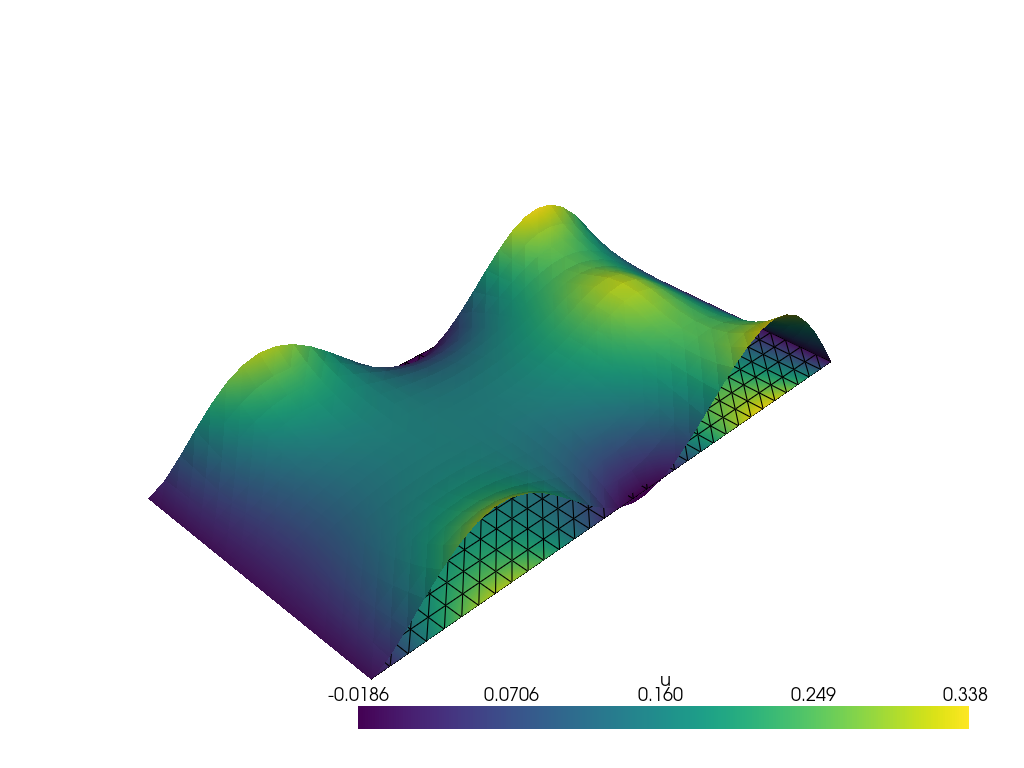

In [10]:
try:
    import pyvista
    cells, types, x = plot.vtk_mesh(V)
    grid = pyvista.UnstructuredGrid(cells, types, x)
    grid.point_data["u"] = uh.x.array.real
    grid.set_active_scalars("u")
    plotter = pyvista.Plotter()
    plotter.add_mesh(grid, show_edges=True)
    warped = grid.warp_by_scalar()
    plotter.add_mesh(warped)
    if pyvista.OFF_SCREEN:
        pyvista.start_xvfb(wait=0.1)
        plotter.screenshot("uh_poisson.png")
    else:
        plotter.show()
except ModuleNotFoundError:
    print("'pyvista' is required to visualise the solution")
    print("Install 'pyvista' with pip: 'python3 -m pip install pyvista'")

In [11]:
-ufl.grad(uh)  # This is the electric field, E, in the context of electrostatics

ComponentTensor(Product(IntValue(-1), Indexed(Grad(Coefficient(FunctionSpace(Mesh(blocked element (Basix element (P, triangle, 1, gll_warped, unset, False, float64, []), (2,)), 0), Basix element (P, triangle, 1, gll_warped, unset, False, float64, [])), 0)), MultiIndex((Index(8),)))), MultiIndex((Index(8),)))

In [12]:
# Method 1: Convert to Function using interpolation (fastest)
E_expr = -ufl.grad(uh)
mesh = uh.function_space.mesh
gdim = mesh.geometry.dim
V_vector = fem.functionspace(mesh, ("Lagrange", 1, (gdim,)))
E = fem.Function(V_vector)
E.interpolate(fem.Expression(E_expr, V_vector.element.interpolation_points()))

# Now E contains your electric field values
print(f"Electric field function: {E}")

Electric field function: f


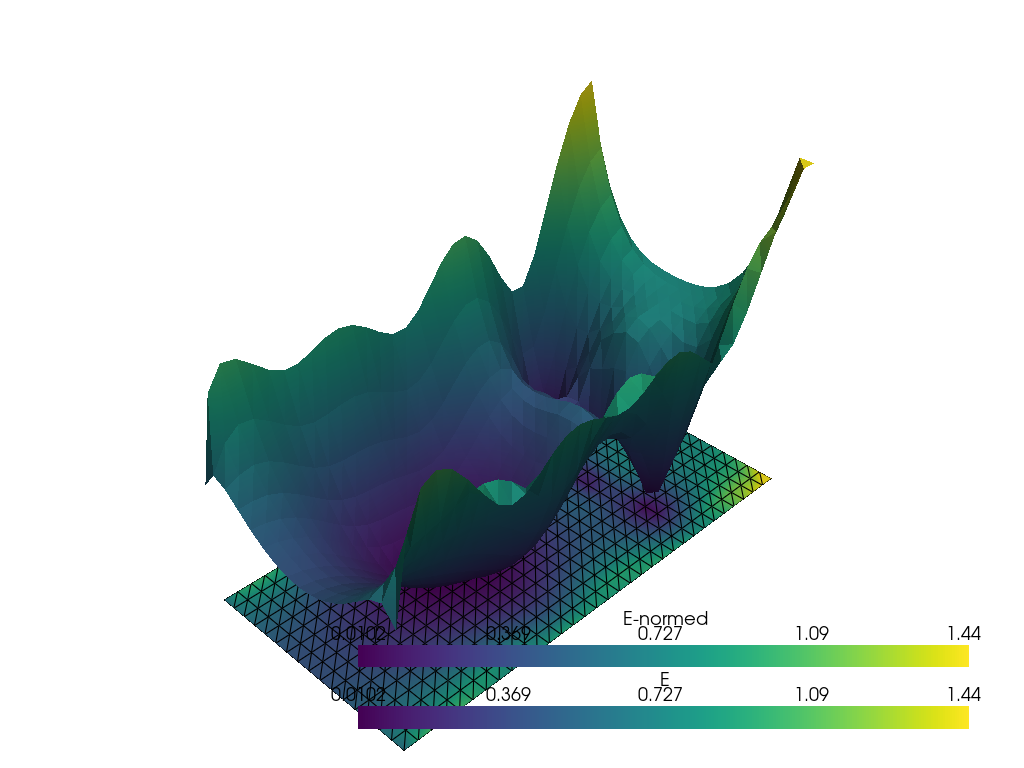

In [13]:
try:
    import pyvista
    cells, types, x = plot.vtk_mesh(V)
    grid = pyvista.UnstructuredGrid(cells, types, x)
    # Reshape E to (n_points, gdim) for vector field visualization
    grid.point_data["E"] = E.x.array.real.reshape((x.shape[0], gdim))

    plotter = pyvista.Plotter()
    plotter.add_mesh(grid, show_edges=True)
    warped = grid.warp_by_scalar()
    plotter.add_mesh(warped)
    if pyvista.OFF_SCREEN:
        pyvista.start_xvfb(wait=0.1)
        plotter.screenshot("E_poisson.png")
    else:
        plotter.show()
except ModuleNotFoundError:
    print("'pyvista' is required to visualise the solution")
    print("Install 'pyvista' with pip: 'python3 -m pip install pyvista'")

In [14]:
E

Coefficient(FunctionSpace(Mesh(blocked element (Basix element (P, triangle, 1, gll_warped, unset, False, float64, []), (2,)), 0), blocked element (Basix element (P, triangle, 1, gll_warped, unset, False, float64, []), (2,))), 1)

In [15]:
uh

Coefficient(FunctionSpace(Mesh(blocked element (Basix element (P, triangle, 1, gll_warped, unset, False, float64, []), (2,)), 0), Basix element (P, triangle, 1, gll_warped, unset, False, float64, [])), 0)

In [16]:
E.x.array.shape

(1122,)

In [17]:
# Get the coordinates of the mesh nodes
coords = E.function_space.mesh.geometry.x
# Get the electric field values at each node
E_values = E.x.array.reshape((-1, E.function_space.mesh.geometry.dim))

# Print coordinates and corresponding E values
for i, (pt, val) in enumerate(zip(coords, E_values)):
    print(f"Node {i}: x = {pt}, E = {val}")

Node 0: x = [1.9375 0.     0.    ], E = [ 0.89918421 -0.07903111]
Node 1: x = [2. 0. 0.], E = [0.54203945 0.        ]
Node 2: x = [2.     0.0625 0.    ], E = [0.62107055 0.        ]
Node 3: x = [1.9375 0.0625 0.    ], E = [0.72587269 0.02577103]
Node 4: x = [1.875 0.    0.   ], E = [0.98903745 0.09428042]
Node 5: x = [2.    0.125 0.   ], E = [0.59529952 0.        ]
Node 6: x = [1.875  0.0625 0.    ], E = [0.76210158 0.1305093 ]
Node 7: x = [1.9375 0.125  0.    ], E = [0.62113442 0.05160594]
Node 8: x = [1.8125 0.     0.    ], E = [0.9284091  0.32121629]
Node 9: x = [2.     0.1875 0.    ], E = [0.54369358 0.        ]
Node 10: x = [1.8125 0.0625 0.    ], E = [0.71343724 0.27255195]
Node 11: x = [1.875 0.125 0.   ], E = [0.62005893 0.12943381]
Node 12: x = [1.9375 0.1875 0.    ], E = [0.54330654 0.0512189 ]
Node 13: x = [1.75 0.   0.  ], E = [0.76147249 0.53618815]
Node 14: x = [2.   0.25 0.  ], E = [0.49247469 0.        ]
Node 15: x = [1.75   0.0625 0.    ], E = [0.5912827  0.41403361]
N

In [18]:
# E_values is shape (num_nodes, 2)
Ez = np.zeros((E_values.shape[0], 1))
E_values_padded = np.hstack([E_values, Ez])

# Now E_values_padded is shape (num_nodes, 3)
E_values_padded[10:40]

array([[ 0.71343724,  0.27255195,  0.        ],
       [ 0.62005893,  0.12943381,  0.        ],
       [ 0.54330654,  0.0512189 ,  0.        ],
       [ 0.76147249,  0.53618815,  0.        ],
       [ 0.49247469,  0.        ,  0.        ],
       [ 0.5912827 ,  0.41403361,  0.        ],
       [ 0.57195558,  0.22444861,  0.        ],
       [ 0.52504413,  0.1111714 ,  0.        ],
       [ 0.48335404,  0.04209825,  0.        ],
       [ 0.51870842,  0.70637794,  0.        ],
       [ 0.45037643,  0.        ,  0.        ],
       [ 0.41372296,  0.52881819,  0.        ],
       [ 0.47649812,  0.31857615,  0.        ],
       [ 0.47782804,  0.17723252,  0.        ],
       [ 0.45898302,  0.08680038,  0.        ],
       [ 0.43865191,  0.03037373,  0.        ],
       [ 0.23006868,  0.8113634 ,  0.        ],
       [ 0.42000271,  0.        ,  0.        ],
       [ 0.20201869,  0.59965913,  0.        ],
       [ 0.34288202,  0.39520209,  0.        ],
       [ 0.39987219,  0.2406203 ,  0.   

In [19]:
r13 = 10
r22 = 6.8
r33 = 32.2
r51 = 32.0

r_voigt = np.array([
    [0,    0,    0,     0,   r13, 0],
    [0,    0,    0,    r13,   0,  0],
    [r33, r33, r33,     0,   0,   0]
])

r_voigt *= 1e-12

# Refractive index (assuming uniaxial crystal)
n0 = 2.2

In [20]:
# For each node, multiply E_values_padded (1x3) by r_voigt (3x6) to get (1x6)
eta = E_values_padded @ r_voigt  # shape: (561, 6)
eta

array([[ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        -7.90311054e-13,  8.99184213e-12,  0.00000000e+00],
       [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  5.42039447e-12,  0.00000000e+00],
       [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  6.21070552e-12,  0.00000000e+00],
       ...,
       [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00, -1.42085628e-11,  0.00000000e+00],
       [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00, -1.42085628e-11,  0.00000000e+00],
       [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00, -1.42085628e-11,  0.00000000e+00]],
      shape=(561, 6))

## Gaussian vs sine modulated gaussian pulse

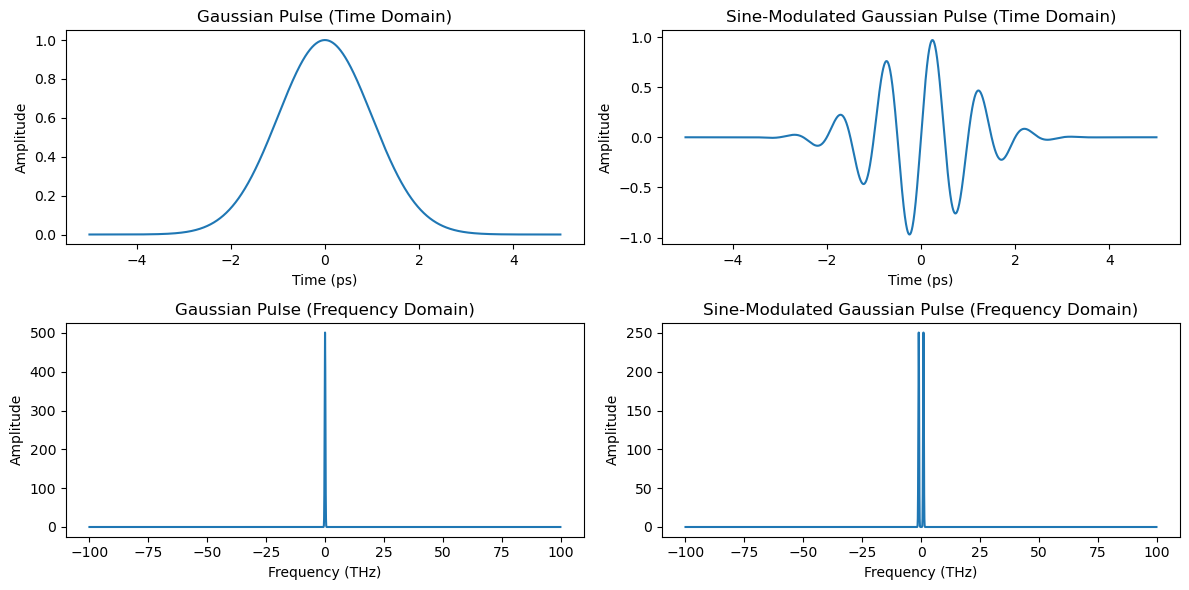

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.fft import fft, fftfreq, fftshift

# Time array
t = np.linspace(-5e-12, 5e-12, 2000)  # from -5 ps to 5 ps
sigma = 1e-12                        # pulse width (1 ps)
t0 = 0

# Gaussian pulse (no carrier)
gaussian = np.exp(-((t - t0)**2) / (2 * sigma**2))

# Sine-modulated Gaussian pulse (with carrier)
fc = 1e12  # 1 THz
sine_modulated = gaussian * np.sin(2 * np.pi * fc * t)

# Compute frequency spectrum
dt = t[1] - t[0]
freqs = fftshift(fftfreq(len(t), dt))
gauss_spectrum = fftshift(np.abs(fft(gaussian)))
sine_spec = fftshift(np.abs(fft(sine_modulated)))

# Plotting
plt.figure(figsize=(12, 6))

# Time domain
plt.subplot(2, 2, 1)
plt.plot(t * 1e12, gaussian)
plt.title('Gaussian Pulse (Time Domain)')
plt.xlabel('Time (ps)')
plt.ylabel('Amplitude')

plt.subplot(2, 2, 2)
plt.plot(t * 1e12, sine_modulated)
plt.title('Sine-Modulated Gaussian Pulse (Time Domain)')
plt.xlabel('Time (ps)')
plt.ylabel('Amplitude')

# Frequency domain
plt.subplot(2, 2, 3)
plt.plot(freqs * 1e-12, gauss_spectrum)
plt.title('Gaussian Pulse (Frequency Domain)')
plt.xlabel('Frequency (THz)')
plt.ylabel('Amplitude')

plt.subplot(2, 2, 4)
plt.plot(freqs * 1e-12, sine_spec)
plt.title('Sine-Modulated Gaussian Pulse (Frequency Domain)')
plt.xlabel('Frequency (THz)')
plt.ylabel('Amplitude')

plt.tight_layout()
plt.show()


## Phase shift

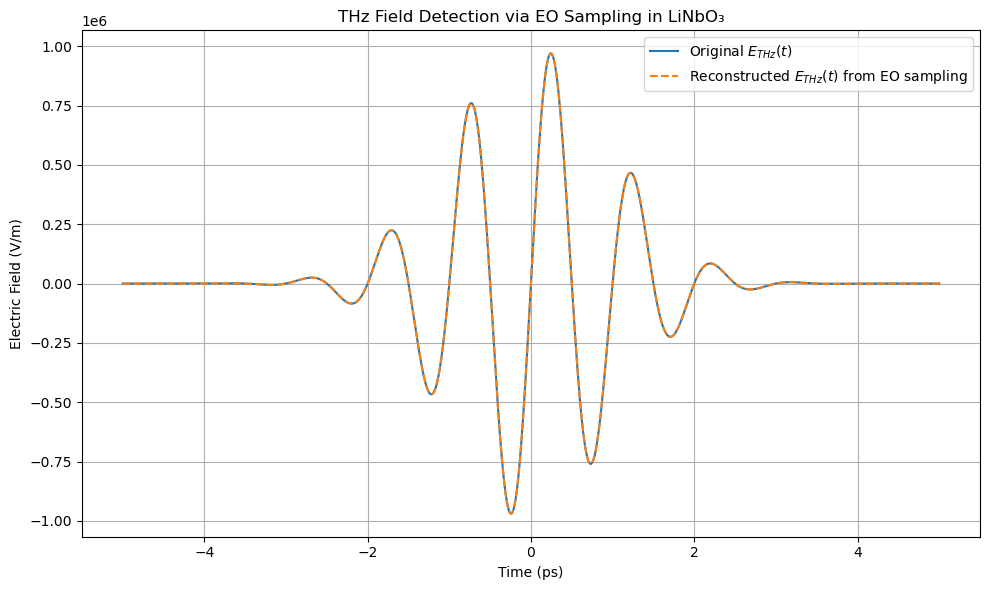

In [2]:
import numpy as np
import matplotlib.pyplot as plt

# Constants
lambda_probe = 800e-9          # probe wavelength (800 nm)
n0 = 2.2                       # refractive index of LiNbO3 at 800 nm
r33 = 30.8e-12                 # electro-optic coefficient r33 in m/V
d = 0.5e-3                     # EO crystal thickness = 0.5 mm

# Time array
t = np.linspace(-5e-12, 5e-12, 2000)  # from -5 ps to 5 ps

# Simulated THz electric field: sine-modulated Gaussian pulse
f_thz = 1e12  # 1 THz
sigma = 1e-12
E0 = 1e6  # 100 kV/cm = 1e6 V/m
E_thz = E0 * np.exp(-t**2 / (2 * sigma**2)) * np.sin(2 * np.pi * f_thz * t)

# Phase shift induced by THz field
delta_phi = (2 * np.pi / lambda_probe) * n0**3 * r33 * d * E_thz  # in radians

# Detector signal approximation (small-angle)
signal = delta_phi  # proportional to E_thz

# Reconstruct E_thz from the signal
E_reconstructed = (lambda_probe / (2 * np.pi * n0**3 * r33 * d)) * signal

# Plotting
plt.figure(figsize=(10, 6))
plt.plot(t * 1e12, E_thz, label='Original $E_{THz}(t)$')
plt.plot(t * 1e12, E_reconstructed, '--', label='Reconstructed $E_{THz}(t)$ from EO sampling')
plt.xlabel('Time (ps)')
plt.ylabel('Electric Field (V/m)')
plt.title('THz Field Detection via EO Sampling in LiNbO₃')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


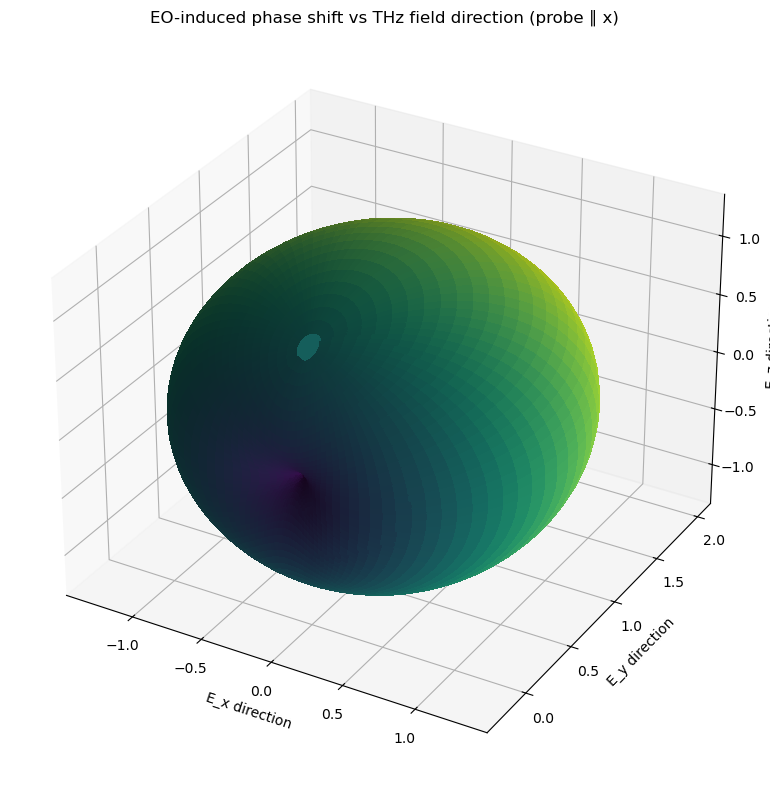

In [3]:
import numpy as np
import matplotlib.pyplot as plt

# EO coefficients for LiNbO3 in m/V
r13 = 8.6e-12
r33 = 30.8e-12
r51 = 32.0e-12

# Initialize full EO tensor r_ijk for 3x3x3 (i,j,k)
r = np.zeros((3, 3, 3))

# Assign nonzero components (x=0, y=1, z=2)
r[2, 0, 0] = r13  # r_zxx
r[2, 1, 1] = r13  # r_zyy
r[2, 2, 2] = r33  # r_zzz
r[1, 0, 1] = r51  # r_yxy
r[1, 1, 0] = r51  # r_yyx
r[0, 0, 1] = r51  # r_xxy
r[0, 1, 0] = r51  # r_xyx

# Define a grid of THz electric field directions on the unit sphere
phi = np.linspace(0, 2 * np.pi, 100)
theta = np.linspace(0, np.pi, 50)
phi, theta = np.meshgrid(phi, theta)

# Convert spherical to Cartesian: E_x, E_y, E_z
Ex = np.sin(theta) * np.cos(phi)
Ey = np.sin(theta) * np.sin(phi)
Ez = np.cos(theta)

# Probe polarization vector (e.g., linear along x)
ep = np.array([1, 0, 0])

# Compute Δphi for each field direction
Delta_phi = np.zeros_like(Ex)
for i in range(3):
    for j in range(3):
        for k in range(3):
            Delta_phi += ep[i] * r[i, j, k] * ep[j] * (Ex * (k == 0) + Ey * (k == 1) + Ez * (k == 2))

# Normalize for visualization
Delta_phi_normalized = Delta_phi / np.max(np.abs(Delta_phi))

# 3D surface plot on unit sphere
x = Ex * (1 + Delta_phi_normalized)
y = Ey * (1 + Delta_phi_normalized)
z = Ez * (1 + Delta_phi_normalized)

fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')
surf = ax.plot_surface(x, y, z, facecolors=plt.cm.viridis((Delta_phi_normalized + 1) / 2), rstride=1, cstride=1, antialiased=False)
ax.set_title("EO-induced phase shift vs THz field direction (probe ∥ x)")
ax.set_xlabel("E_x direction")
ax.set_ylabel("E_y direction")
ax.set_zlabel("E_z direction")
plt.tight_layout()
plt.show()


| Notation  | Interpretation                                                  |
| --------- | --------------------------------------------------------------- |
| $r_{zxx}$ | E-field along $x$ affects optical property in $z$-$x$ direction |
| $r_{yyy}$ | E-field along $y$ affects birefringence in $y$-$y$              |
| $r_{yxy}$ | E-field along $y$ affects $y$-$x$ birefringence                 |
| $r_{xxy}$ | E-field along $y$ affects $x$-$x$ birefringence                 |


In [5]:
import numpy as np

# Constants
lambda_probe = 800e-9  # probe wavelength in meters
d = 0.5e-3             # EO crystal thickness in meters
n0 = 2.2               # approximate refractive index for LiNbO3 at 800 nm

# Define THz electric field vector (V/m)
E_thz = np.array([1e6, 2e6, 3e6])  # E_x, E_y, E_z

# Define probe polarization vector (unit vector)
e_probe = np.array([1, 0, 0])  # linear polarization along x

# EO coefficients for LiNbO3 in m/V
r13 = 8.6e-12
r33 = 30.8e-12
r51 = 32.0e-12

# Initialize full r_ijk tensor (3x3x3)
r = np.zeros((3, 3, 3))

# Assign nonzero components (x=0, y=1, z=2)
r[2, 0, 0] = r13  # r_zxx
r[2, 1, 1] = r13  # r_zyy
r[2, 2, 2] = r33  # r_zzz
r[1, 0, 1] = r51  # r_yxy
r[1, 1, 0] = r51  # r_yyx
r[0, 0, 1] = r51  # r_xxy
r[0, 1, 0] = r51  # r_xyx

# Compute delta_phi using full tensor contraction
delta_phi = 0.0
for i in range(3):
    for j in range(3):
        for k in range(3):
            delta_phi += e_probe[i] * r[i, j, k] * E_thz[k] * e_probe[j]

# Multiply by common prefactor
delta_phi *= (2 * np.pi / lambda_probe) * d * n0**3  # in radians

delta_phi


np.float64(2.67613428603393)

In [6]:
r

array([[[0.00e+00, 3.20e-11, 0.00e+00],
        [3.20e-11, 0.00e+00, 0.00e+00],
        [0.00e+00, 0.00e+00, 0.00e+00]],

       [[0.00e+00, 3.20e-11, 0.00e+00],
        [3.20e-11, 0.00e+00, 0.00e+00],
        [0.00e+00, 0.00e+00, 0.00e+00]],

       [[8.60e-12, 0.00e+00, 0.00e+00],
        [0.00e+00, 8.60e-12, 0.00e+00],
        [0.00e+00, 0.00e+00, 3.08e-11]]])